# Step 1: Imports and Setup

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from pathlib import Path
from datetime import datetime
from torch_geometric.data import Data


IMAGES_DIR = Path("../artifacts/images/")
PROCESSED_DIR = Path("../data/processed/")
MODELS_DIR = Path("../artifacts/models")
timestamp = datetime.now().strftime("%d-%m-%Y")

# Configuration

In [2]:
RANDOM_SEED = 42
FEATURE_DIM = 64
HIDDEN_DIM = 128
NEGATIVE_SAMPLE_RATIO = 3
EPOCHS = 50
PATIENCE_LIMIT = 15

# Visualization
GRAPH_VISALIZATION_NODES_NUMBER = 5000

# Recommendations 
RECOMMENDATIONS_NUMBER = 10000

# Reproducibility

In [3]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Step 2: Load Data

In [4]:
meta_df = pd.read_csv("../data/raw/meta.csv")
reviews_df = pd.read_csv("../data/raw/reviews.csv")

# Step 3: Filter and Encode

In [5]:
reviews_df = reviews_df.sample(n=13000, random_state=RANDOM_SEED)
filtered_item_ids = reviews_df['parent_asin'].unique()
meta_df = meta_df[meta_df['parent_asin'].isin(filtered_item_ids)]

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
reviews_df['user_idx'] = user_encoder.fit_transform(reviews_df['user_id'])
reviews_df['item_idx'] = item_encoder.fit_transform(reviews_df['parent_asin'])

user_id_map = dict(zip(reviews_df['user_id'], reviews_df['user_idx']))
item_id_map = dict(zip(reviews_df['parent_asin'], reviews_df['item_idx']))

# Step 4: Feature Engineering

In [6]:
numerical_features = ['price', 'average_rating', 'rating_number']
categorical_features = ['main_category', 'store']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]), categorical_features)
])

meta_df_clean = meta_df.drop_duplicates('parent_asin').reset_index(drop=True)
meta_features = preprocessor.fit_transform(meta_df_clean[numerical_features + categorical_features])
meta_tensor = torch.tensor(meta_features.toarray() if hasattr(meta_features, 'toarray') else meta_features, dtype=torch.float32)

projection_layer = nn.Linear(meta_tensor.size(1), FEATURE_DIM)
with torch.no_grad():
    projected_meta = projection_layer(meta_tensor)

num_items = reviews_df['item_idx'].nunique()
item_features = torch.zeros(num_items, FEATURE_DIM)
asin_to_idx = {asin: i for i, asin in enumerate(meta_df_clean['parent_asin'])}

for asin, idx in item_id_map.items():
    if asin in asin_to_idx and idx < num_items:
        item_features[idx] = projected_meta[asin_to_idx[asin]]

# Step 5: Build Graph

In [7]:
edge_index = torch.tensor([
    reviews_df['user_idx'].values,
    reviews_df['item_idx'].values
], dtype=torch.long)

ratings = torch.tensor(reviews_df['rating'].values, dtype=torch.float)

data = HeteroData()
data['user'].x = torch.randn(reviews_df['user_idx'].nunique(), FEATURE_DIM)
data['item'].x = item_features

data['user', 'rates', 'item'].edge_index = edge_index
data['user', 'rates', 'item'].edge_weight = ratings

data['item', 'rev_rates', 'user'].edge_index = edge_index.flip(0)
data['item', 'rev_rates', 'user'].edge_weight = ratings

/tmp/ipykernel_27858/2215603360.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([


# Step 6: Split Graph

In [8]:
transform = RandomLinkSplit(
    num_val=0.1, num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    edge_types=[('user', 'rates', 'item')],
    rev_edge_types=[('item', 'rev_rates', 'user')]
)
train_data, val_data, test_data = transform(data)

# Step 7: Save Graphs

In [9]:
torch.save(data, PROCESSED_DIR / "graph_full_data.pt")
torch.save(train_data, PROCESSED_DIR / "graph_train_data.pt")
torch.save(val_data, PROCESSED_DIR / "graph_val_data.pt")
torch.save(test_data, PROCESSED_DIR / "graph_test_data.pt")

print("✅ Graphs saved:")
print("- Full graph → graph_full_data.pt")
print("- Train graph → graph_train_data.pt")
print("- Validation graph → graph_val_data.pt")
print("- Test graph → graph_test_data.pt")

✅ Graphs saved:
- Full graph → graph_full_data.pt
- Train graph → graph_train_data.pt
- Validation graph → graph_val_data.pt
- Test graph → graph_test_data.pt


# Step 8: Plot Graph

/home/abdalrhman/Desktop/Graduation Project/AiStore/venv/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


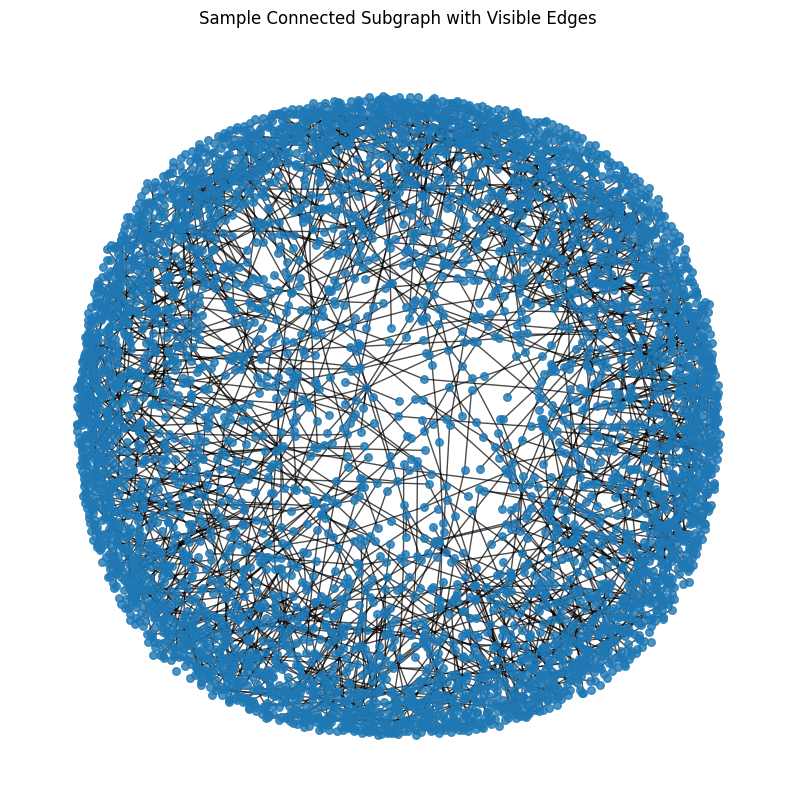

In [10]:
# Build homogeneous graph from bipartite edge index
edge_index = data['user', 'rates', 'item'].edge_index
homogeneous = Data(edge_index=edge_index)
G = to_networkx(homogeneous, to_undirected=True)

# Get largest connected component (avoid isolated nodes)
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(list(largest_cc)[:GRAPH_VISALIZATION_NODES_NUMBER]).copy()

# Plot
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(subgraph, seed=42, k=0.1)
nx.draw_networkx_nodes(subgraph, pos, node_size=30, alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, width=1, alpha=0.7)
plt.title("Sample Connected Subgraph with Visible Edges")
plt.axis("off")
plt.savefig(os.path.join(IMAGES_DIR, 'graph_plot.png'))
plt.show()

# Step 9: Define Models

In [11]:
class HeteroGraphSAGE(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.conv1 = HeteroConv({
            ('user', 'rates', 'item'): SAGEConv((-1, -1), hidden_dim),
            ('item', 'rev_rates', 'user'): SAGEConv((-1, -1), hidden_dim)
        }, aggr='mean')
        self.conv2 = HeteroConv({
            ('user', 'rates', 'item'): SAGEConv(hidden_dim, hidden_dim),
            ('item', 'rev_rates', 'user'): SAGEConv(hidden_dim, hidden_dim)
        }, aggr='mean')
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: self.bn1(v) for k, v in x_dict.items()}
        x_dict = {k: self.dropout(F.leaky_relu(v)) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: self.bn2(v) for k, v in x_dict.items()}
        return x_dict

class LinkPredictor(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            Linear(hidden_dim, 1)
        )

    def forward(self, src, dst):
        return self.mlp(torch.cat([src, dst], dim=-1)).squeeze()

# Step 10: Training Setup

In [12]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gnn = HeteroGraphSAGE(HIDDEN_DIM).to(device)
predictor = LinkPredictor(HIDDEN_DIM).to(device)

train_data, val_data, test_data = [d.to(device) for d in [train_data, val_data, test_data]]

optimizer = torch.optim.AdamW(list(gnn.parameters()) + list(predictor.parameters()), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

metrics_log = []
best_f1 = 0.0
patience = 0

@torch.no_grad()
def evaluate(data):
    gnn.eval()
    predictor.eval()
    emb = gnn(data.x_dict, data.edge_index_dict)
    src, dst = data['user', 'rates', 'item'].edge_index
    pos_pred = predictor(emb['user'][src], emb['item'][dst])
    pos_labels = torch.ones(len(pos_pred))

    neg_src = src[:len(src)//2]
    neg_dst = torch.randint(0, num_items, (len(neg_src),), device=device)
    neg_pred = predictor(emb['user'][neg_src], emb['item'][neg_dst])
    neg_labels = torch.zeros(len(neg_pred))

    scores = torch.cat([pos_pred, neg_pred]).cpu().numpy()
    labels = torch.cat([pos_labels, neg_labels]).cpu().numpy()
    auc = roc_auc_score(labels, scores)
    precisions, recalls, thresholds = precision_recall_curve(labels, scores)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    return {
        'auc': auc,
        'precision': precisions[best_idx],
        'recall': recalls[best_idx],
        'f1': f1_scores[best_idx],
        'threshold': thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    }

def train_epoch(data):
    gnn.train()
    predictor.train()
    optimizer.zero_grad()
    emb = gnn(data.x_dict, data.edge_index_dict)
    src, dst = data['user', 'rates', 'item'].edge_index
    pos_pred = predictor(emb['user'][src], emb['item'][dst])

    neg_src = src[:len(src)//2]
    neg_dst = torch.randint(0, num_items, (len(neg_src),), device=device)
    neg_pred = predictor(emb['user'][neg_src], emb['item'][neg_dst])

    loss = F.binary_cross_entropy_with_logits(
        torch.cat([pos_pred, neg_pred]),
        torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])
    )
    loss.backward()
    optimizer.step()
    return loss.item()

# Step 11: Run Training

In [13]:
for epoch in range(1, EPOCHS + 1):
    loss = train_epoch(train_data)
    val = evaluate(val_data)
    scheduler.step(val['f1'])

    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | AUC: {val['auc']:.4f} | F1: {val['f1']:.4f} | "
          f"Prec: {val['precision']:.4f} | Rec: {val['recall']:.4f} | Thresh: {val['threshold']:.4f}")

    metrics_log.append((epoch, loss, val['auc'], val['f1'], val['precision'], val['recall'], val['threshold']))
    if val['f1'] > best_f1:
        best_f1 = val['f1']
        patience = 0
    else:
        patience += 1
        if patience >= PATIENCE_LIMIT:
            print("Early stopping triggered.")
            break


Epoch 01 | Loss: 0.7235 | AUC: 0.6156 | F1: 0.8183 | Prec: 0.6986 | Rec: 0.9875 | Thresh: -0.0106
Epoch 02 | Loss: 0.6863 | AUC: 0.6266 | F1: 0.8245 | Prec: 0.7025 | Rec: 0.9979 | Thresh: 0.0572
Epoch 03 | Loss: 0.6559 | AUC: 0.6317 | F1: 0.8278 | Prec: 0.7067 | Rec: 0.9990 | Thresh: 0.1310
Epoch 04 | Loss: 0.6327 | AUC: 0.6335 | F1: 0.8275 | Prec: 0.7059 | Rec: 0.9996 | Thresh: 0.1979
Epoch 05 | Loss: 0.6150 | AUC: 0.6396 | F1: 0.8298 | Prec: 0.7092 | Rec: 1.0000 | Thresh: 0.2520
Epoch 06 | Loss: 0.5973 | AUC: 0.6370 | F1: 0.8296 | Prec: 0.7088 | Rec: 1.0000 | Thresh: 0.3444
Epoch 07 | Loss: 0.5860 | AUC: 0.6391 | F1: 0.8288 | Prec: 0.7077 | Rec: 0.9998 | Thresh: 0.4528
Epoch 08 | Loss: 0.5781 | AUC: 0.6476 | F1: 0.8301 | Prec: 0.7095 | Rec: 1.0000 | Thresh: 0.5200
Epoch 09 | Loss: 0.5674 | AUC: 0.6612 | F1: 0.8314 | Prec: 0.7114 | Rec: 1.0000 | Thresh: 0.6008
Epoch 10 | Loss: 0.5645 | AUC: 0.6718 | F1: 0.8299 | Prec: 0.7092 | Rec: 1.0000 | Thresh: 0.6596
Epoch 11 | Loss: 0.5560 | AUC

# Step 12: Save Trained Model

In [14]:
model_filename = f"gnn_model_{timestamp}.pt"

# Save model checkpoint
torch.save({
    'gnn_state_dict': gnn.state_dict(),
    'predictor_state_dict': predictor.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_f1': best_f1,
    'metrics_log': metrics_log
}, MODELS_DIR / model_filename)

print(f"✅ Trained model saved to: {MODELS_DIR / model_filename}")

✅ Trained model saved to: ../artifacts/models/gnn_model_13-06-2025.pt


# Step 13: Training Plots

In [15]:
# Extract each list from metrics_log
epochs_list = [m[0] for m in metrics_log]
losses_list = [m[1] for m in metrics_log]
aucs_list = [m[2] for m in metrics_log]
f1s_list = [m[3] for m in metrics_log]
precisions_list = [m[4] for m in metrics_log]
recalls_list = [m[5] for m in metrics_log]
thresholds_list = [m[6] for m in metrics_log]

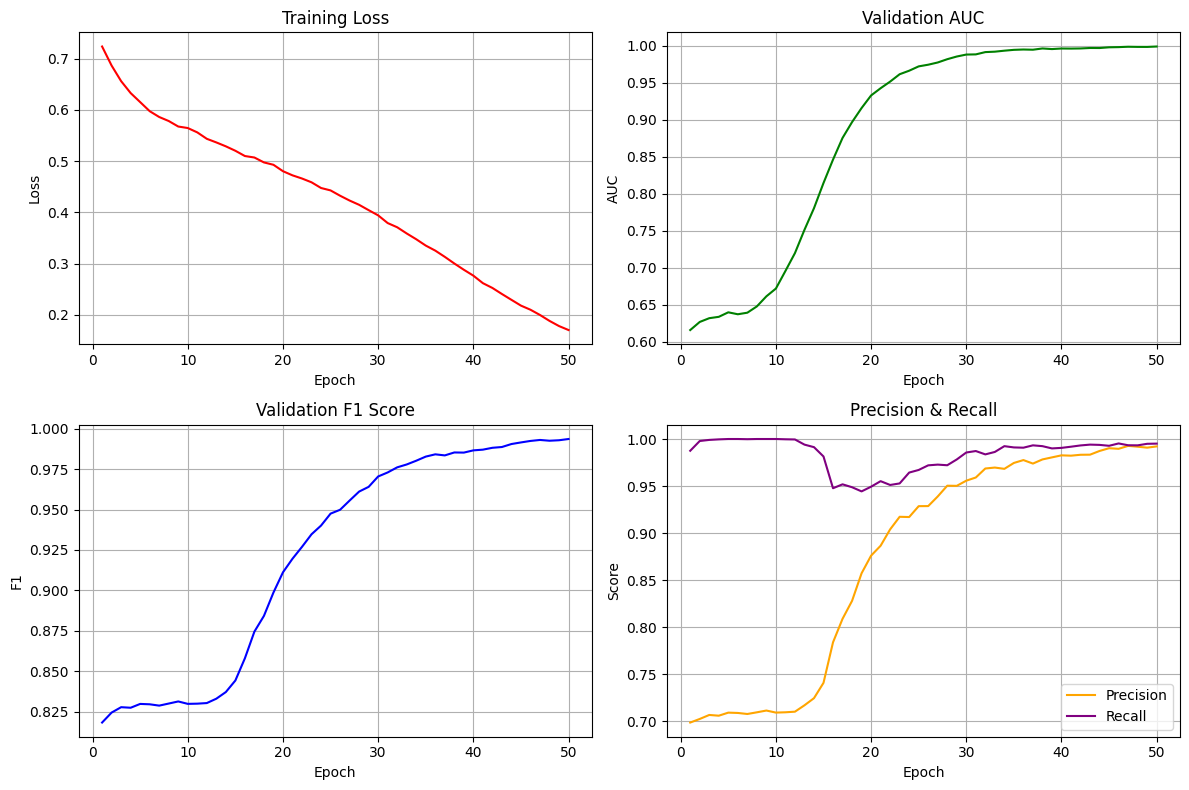

In [16]:
# Plot training metrics
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_list, losses_list, label="Train Loss", color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# AUC
plt.subplot(2, 2, 2)
plt.plot(epochs_list, aucs_list, label="Val AUC", color='green')
plt.title("Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(True)

# F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs_list, f1s_list, label="Val F1", color='blue')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid(True)

# Precision & Recall
plt.subplot(2, 2, 4)
plt.plot(epochs_list, precisions_list, label="Precision", color='orange')
plt.plot(epochs_list, recalls_list, label="Recall", color='purple')
plt.title("Precision & Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'model_evaluation.png'))
plt.show()

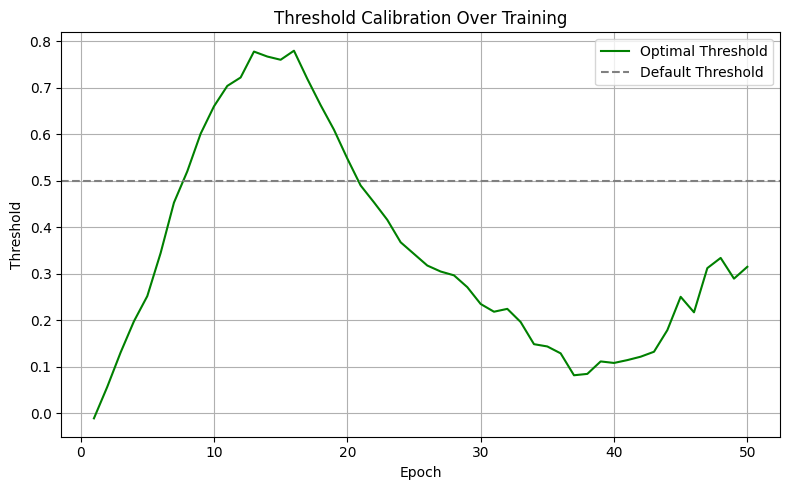

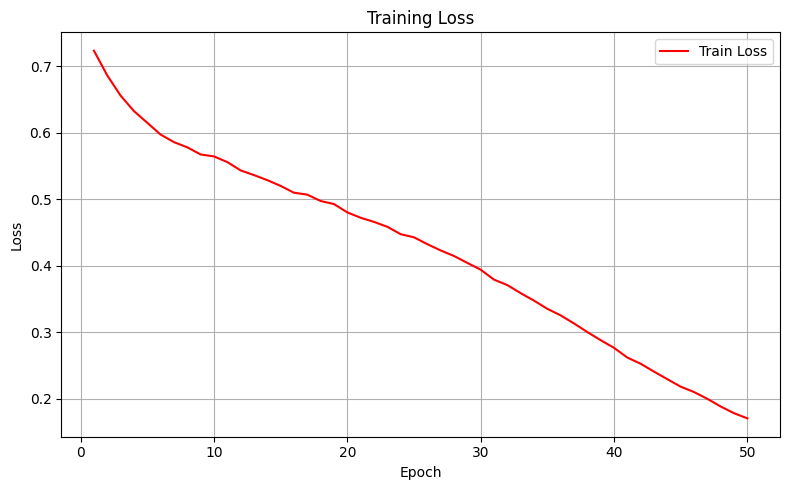

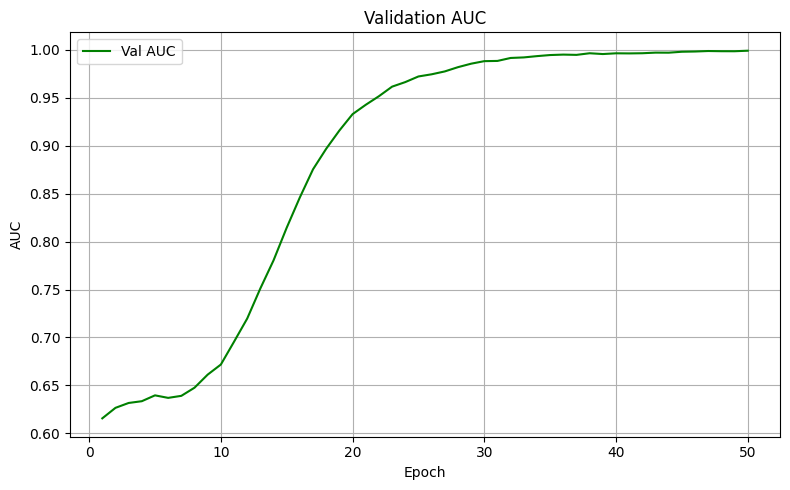

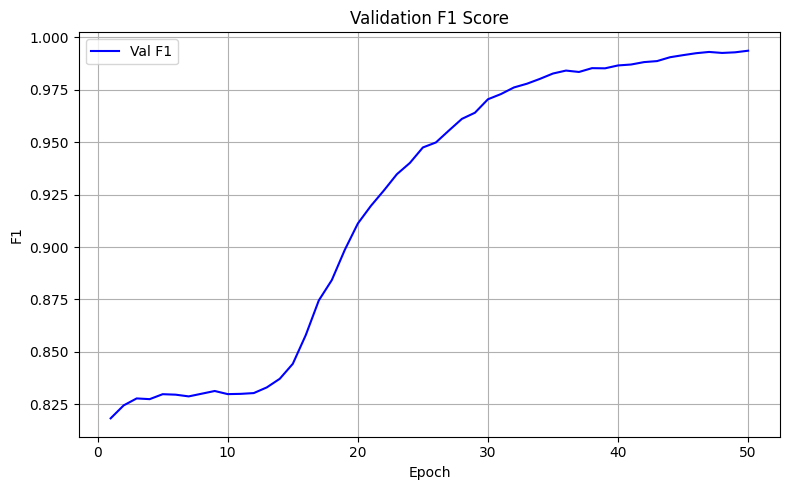

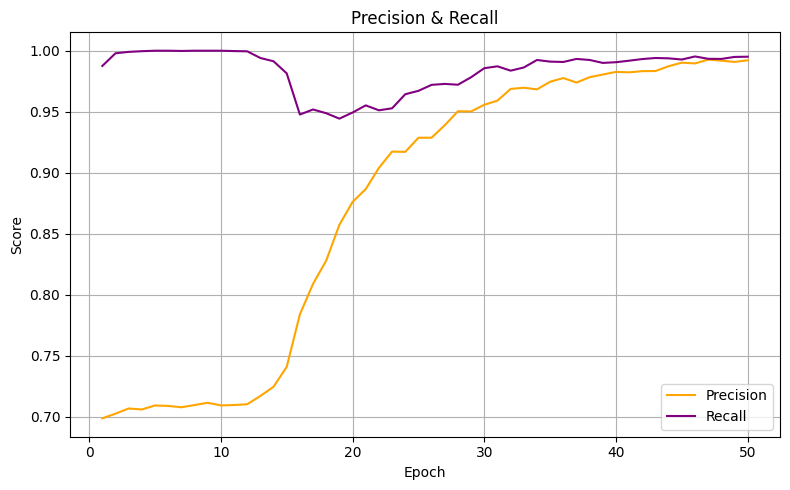

In [17]:
# Threshold plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, thresholds_list, label="Optimal Threshold", color='green')
plt.axhline(y=0.5, color='gray', linestyle='--', label="Default Threshold")
plt.title("Threshold Calibration Over Training")
plt.xlabel("Epoch")
plt.ylabel("Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(IMAGES_DIR / f"threshold_plot_{timestamp}.png")
plt.show()


# Training plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, losses_list, label="Train Loss", color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'training_plot_.png'))
plt.show()


# AUC plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, aucs_list, label="Val AUC", color='green')
plt.title("Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'AUC.png'))
plt.show()

# Validation F1 Score plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, f1s_list, label="Val F1", color='blue')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'Validation_f1_score.png'))
plt.show()


# Precision & Recall
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, precisions_list, label="Precision", color='orange')
plt.plot(epochs_list, recalls_list, label="Recall", color='purple')
plt.title("Precision & Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'percision_recall.png'))
plt.show()

# Step 14: Recommendation Utility

In [18]:
# Build reverse map
id_to_item = {v: k for k, v in item_id_map.items()}

# Load original full metadata
full_meta_df = pd.read_csv("../data/raw/meta.csv")
asin_to_title = dict(zip(full_meta_df['parent_asin'], full_meta_df.get('title', [None] * len(full_meta_df))))
asin_to_category = dict(zip(full_meta_df['parent_asin'], full_meta_df.get('main_category', [None] * len(full_meta_df))))

In [19]:
def recommend_top_k(user_id_str, k=5):
    gnn.eval()
    predictor.eval()

    # Encode user ID
    user_idx = user_id_map.get(user_id_str)
    if user_idx is None:
        raise ValueError("User ID not found in user_id_map.")

    # Move data to same device as model
    device = next(gnn.parameters()).device
    data_on_device = data.to(device)

    # Generate embeddings
    with torch.no_grad():
        emb = gnn(data_on_device.x_dict, data_on_device.edge_index_dict)
        user_emb = emb["user"][user_idx].repeat(data_on_device["item"].num_nodes, 1)
        item_emb = emb["item"]

        scores = predictor(user_emb, item_emb)
        topk_scores, topk_indices = torch.topk(scores, k=k)

    # Map back to ASINs
    idx_to_asin = {v: k for k, v in item_id_map.items()}

    recommendations = []
    for score, idx in zip(topk_scores, topk_indices):
        idx = int(idx.item())
        asin = idx_to_asin.get(idx, "UNKNOWN")

        recommendations.append({
            "item_id": idx,
            "asin": asin,
            "score": round(float(score), 4),
        })

    return recommendations


In [20]:
def get_recommended_products(recommended_asins, meta_df_clean):
    valid_asins = [asin for asin in recommended_asins if asin in meta_df_clean['parent_asin'].values]
    filtered = meta_df_clean[meta_df_clean['parent_asin'].isin(valid_asins)].copy()
    filtered['asin_order'] = pd.Categorical(filtered['parent_asin'], categories=valid_asins, ordered=True)
    return filtered.sort_values('asin_order').drop('asin_order', axis=1)

In [26]:
user_id = reviews_df['user_id'].iloc[0]
recommendations = recommend_top_k(user_id, k=RECOMMENDATIONS_NUMBER)
recommended_asins = [r['asin'] for r in recommendations]
recommended_products = get_recommended_products(recommended_asins, meta_df_clean)

recommended_products[['parent_asin', 'main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details']].head(30)


,parent_asin,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details
17,B08RYZGXLL,Computers,"Chromebook Case, HESTECH 14-15.4 Neoprene Lapt...",4.5,300,['ADDITIONAL GADGET POCKET: this chromebook ca...,[],15.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Black laptop sleeve', 'url': 'http...",HESTECH,"['Electronics', 'Computers & Accessories', 'La...",{'Product Dimensions': '15.9 x 1 x 11.2 inches...
572,B006JH8T3S,Computers,"Logitech HD Pro Webcam C920, Widescreen Video ...",4.6,30686,['Full HD 1080p video calling (upto 1920 x 108...,"['HD Pro Webcam C920', 'With the Logitech HD P...",64.49,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Pros and Cons of the Logitech C920...,Logitech,"['Electronics', 'Computers & Accessories', 'Co...","{'Standing screen display size': '3 Inches', '..."
646,B092W3K376,Amazon Home,Walker Edison Wren Classic 4 Cubby TV Stand fo...,4.6,32181,"['Dimensions: 23.375” H x 15.75” D x 58” L, Op...",['Whether it’s a compact apartment or a lavish...,145.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'My Review Of The Walker Edison Wre...,Walker Edison,"['Electronics', 'Television & Video', 'Accesso...","{'Product Dimensions': '58 x 16 x 24 inches', ..."
412,B078RGL8SB,All Electronics,ELECDER i37 Kids Headphones Children Girls Boy...,4.6,26206,['Excellent Sound: Stereo bass headphone with ...,[],16.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'suitable for kids', 'url': 'https:...",ELECDER,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '8.9 x 2.8 x 6.1 inches...
497,B089SRK8VQ,Cell Phones & Accessories,"Apple iPhone 8 Plus, US Version, 64GB, Gold - ...",4.4,25811,['This device is locked to AT&T only and not c...,['The iPhone 8 Plus is designed with most dura...,195.00,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'iPhone 8 Plus UNBOXING', 'url': 'h...",Amazon Renewed,"['Electronics', 'Bestselling Renewed Smartphon...",{'Product Dimensions': '6.2 x 3.07 x 0.3 inche...
261,B0BTT1Z16D,Computers,"Anker USB C to Lightning Cable, Powerline II [...",4.7,68432,['The Anker Advantage: Join the 55 million+ po...,[],18.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Anker USB C to Lightening Charging...,Anker,"['Electronics', 'Computers & Accessories', 'Co...","{'Brand': 'Anker', 'Connector Type': 'USB Type..."
689,B00JO6RO8C,Computers,SanDisk Cruzer Fit CZ33 32GB USB 2.0 Low-Profi...,4.6,49212,"[""Low-profile drive for notebooks, tablets, TV...","[""With its low-profile design, the Cruzer Fit ...",21.50,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Works great but incomplete', 'url'...",SanDisk,"['Electronics', 'Computers & Accessories', 'Da...","{'RAM': '32 GB', 'Wireless Type': '802.11a', '..."
174,B08529549Q,NaN,"High Sierra Freewheel Wheeled Laptop Backpack,...",4.5,3562,"['Large, multi-compartment design. Fully-padde...",[],84.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'High Sierra Laptop Backpack with W...,High Sierra,"['Electronics', 'Computers & Accessories', 'La...",{'Product Dimensions': '13.5 x 8 x 20.5 inches...
409,B08VWZRB92,All Electronics,"JSAUX USB Type C Cable 3A Fast Charging, [2-Pa...",4.5,17995,"['✅3A Fast Charging and Sync: 3A Fast Charge, ...",[],11.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'JSAUX USB-C to USB-C 10ft 100W Cha...,JSAUX,"['Electronics', 'Computers & Accessories', 'Co...","{'Brand': 'JSAUX', 'Connector Type': 'USB Type..."
763,B00WU0PYXG,Home Audio & Theater,Audio-Technica ATH-ANC7B QuietPoint Active Noi...,4.0,2756,"['Connectivity Technology: Wired', 'QuietPoint...","['These lightweight, compact headphones boast ...",199.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Comparison To Bose Noise Cancellin...,Audio-Technica,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '8.2 x 2.5 x 11 inches